In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/Banglore_traffic_Dataset.csv')

In [ ]:
# Convert 'Date' column from object to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936 entries, 0 to 8935
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Date                                8936 non-null   object 
 1   Area Name                           8936 non-null   object 
 2   Road/Intersection Name              8936 non-null   object 
 3   Traffic Volume                      8936 non-null   int64  
 4   Average Speed                       8936 non-null   float64
 5   Travel Time Index                   8936 non-null   float64
 6   Congestion Level                    8936 non-null   float64
 7   Road Capacity Utilization           8936 non-null   float64
 8   Incident Reports                    8936 non-null   int64  
 9   Environmental Impact                8936 non-null   float64
 10  Public Transport Usage              8936 non-null   float64
 11  Traffic Signal Compliance           8936 no

## Initial Cleaning & Type Conversion

In [ ]:
# Set the date as the index for easier time-series analysis
df.set_index('Date', inplace=True)
df.sort_index(inplace=True) # Ensure data is in chronological order

In [ ]:
# Check for missing values
print(df.isnull().sum())

Area Name                             0
Road/Intersection Name                0
Traffic Volume                        0
Average Speed                         0
Travel Time Index                     0
Congestion Level                      0
Road Capacity Utilization             0
Incident Reports                      0
Environmental Impact                  0
Public Transport Usage                0
Traffic Signal Compliance             0
Parking Usage                         0
Pedestrian and Cyclist Count          0
Weather Conditions                    0
Roadwork and Construction Activity    0
dtype: int64


## Feature Engineering

In [ ]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6
df['month'] = df.index.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Create a 'time_of_day' feature for rush hours
def get_time_of_day(hour):
    if 7 <= hour < 10:
        return 'Morning_Rush'
    elif 10 <= hour < 16:
        return 'Off_Peak'
    elif 16 <= hour < 20:
        return 'Evening_Rush'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(get_time_of_day)

In [ ]:
weather_mapping = {'Clear': 0, 'Cloudy': 1, 'Haze': 2, 'Rain': 3, 'Heavy Rain': 4, 'Thunderstorm': 5}
df['weather_severity'] = df['Weather Conditions'].map(weather_mapping)

In [ ]:
df = pd.get_dummies(df, columns=['Area Name', 'time_of_day'], drop_first=True)

In [ ]:
df['roadwork_binary'] = df['Roadwork and Construction Activity'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create a combined disruption score
df['disruption_score'] = df['Incident Reports'] + df['roadwork_binary']

In [ ]:
# Group by location to prevent data leakage across different roads
grouped = df.groupby('Road/Intersection Name')

# Lag feature (congestion from 1 hour ago)
df['congestion_lag_1hr'] = grouped['Congestion Level'].shift(1)

# Rolling average feature (average congestion over the last 3 hours)
df['congestion_roll_avg_3hr'] = grouped['Congestion Level'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Drop rows with NaN values created by lag/rolling features
df.dropna(inplace=True)

## Data scaling

In [ ]:
# Select only the numerical columns for scaling
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'uint8']).columns
scaler = StandardScaler()

# The scaler will be fit on the training data ONLY to prevent data leakage
# We will do this after splitting the data. This is just for setup.

## Splitting the data

In [ ]:
# Select all numerical columns (including original ints, floats, and new uint8 from get_dummies)
numerical_cols = df.select_dtypes(include=['number']).columns

# This ensures the columns are ready to receive the float output from the scaler
df[numerical_cols] = df[numerical_cols].astype('float64')


# Define a split point
split_point = int(len(df) * 0.8)

# Create explicit copies to avoid SettingWithCopyWarning
train_df = df.iloc[:split_point].copy()
test_df = df.iloc[split_point:].copy()

# Initialize and fit the scaler ONLY on the training data
scaler = StandardScaler()
scaler.fit(train_df[numerical_cols])

# Transform both training and testing data
train_df.loc[:, numerical_cols] = scaler.transform(train_df[numerical_cols])
test_df.loc[:, numerical_cols] = scaler.transform(test_df[numerical_cols])

# Separate features (X) and target (y)
target_column = 'Congestion Level'
X_train = train_df.drop(columns=[target_column, 'Weather Conditions', 'Roadwork and Construction Activity', 'Road/Intersection Name'], errors='ignore')
y_train = train_df[target_column]
X_test = test_df.drop(columns=[target_column, 'Weather Conditions', 'Roadwork and Construction Activity', 'Road/Intersection Name'], errors='ignore')
y_test = test_df[target_column]

In [ ]:
X_train

,Traffic Volume,Average Speed,Travel Time Index,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,...,Area Name_Indiranagar,Area Name_Jayanagar,Area Name_Koramangala,Area Name_M.G. Road,Area Name_Whitefield,Area Name_Yeshwanthpur,roadwork_binary,disruption_score,congestion_lag_1hr,congestion_roll_avg_3hr
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,1.837178,-0.170624,0.758814,0.484097,2.437729,1.837178,-0.573418,-0.409110,-1.428333,-0.342076,...,False,False,False,True,False,False,-0.339126,2.328431,0.818323,1.159093
2022-01-02,-1.714473,-0.434922,-1.837584,-3.569877,-0.388763,-1.714473,-1.583990,-0.412471,0.423259,2.315885,...,False,False,False,False,False,False,-0.339126,-0.454539,0.719247,-1.284182
2022-01-02,0.078286,-0.773677,0.758814,0.484097,0.317860,0.078286,0.143436,1.551449,-0.411392,-0.667540,...,False,False,False,False,False,False,2.948753,0.936946,0.818323,1.159093
2022-01-03,-0.437884,-0.048893,0.035597,0.484097,0.317860,-0.437884,-0.605634,0.619656,0.863685,-0.152221,...,True,False,False,False,False,False,-0.339126,0.241204,-0.099856,0.469032
2022-01-03,-1.531306,0.078484,0.028814,-2.633423,-1.095386,-1.531306,-1.452109,0.982152,0.188430,2.234519,...,False,False,False,False,True,False,-0.339126,-1.150281,-2.231692,-2.798953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-03,-0.500724,0.105094,-1.621856,0.484097,0.317860,-0.500724,-0.588782,0.015253,0.435038,-0.504808,...,False,False,False,False,True,False,-0.339126,0.241204,0.818323,-0.242663
2024-02-03,2.454564,0.935566,0.758814,0.484097,-1.095386,2.454564,0.130147,0.712792,1.451363,-0.206465,...,False,False,True,False,False,False,-0.339126,-1.150281,0.372638,0.948867
2024-02-03,-1.075529,1.098551,0.023637,-0.857282,-0.388763,-1.075529,-0.795770,-0.310827,-1.078756,-0.531930,...,False,False,True,False,False,False,-0.339126,-0.454539,0.818323,0.101676


## Some visualisation

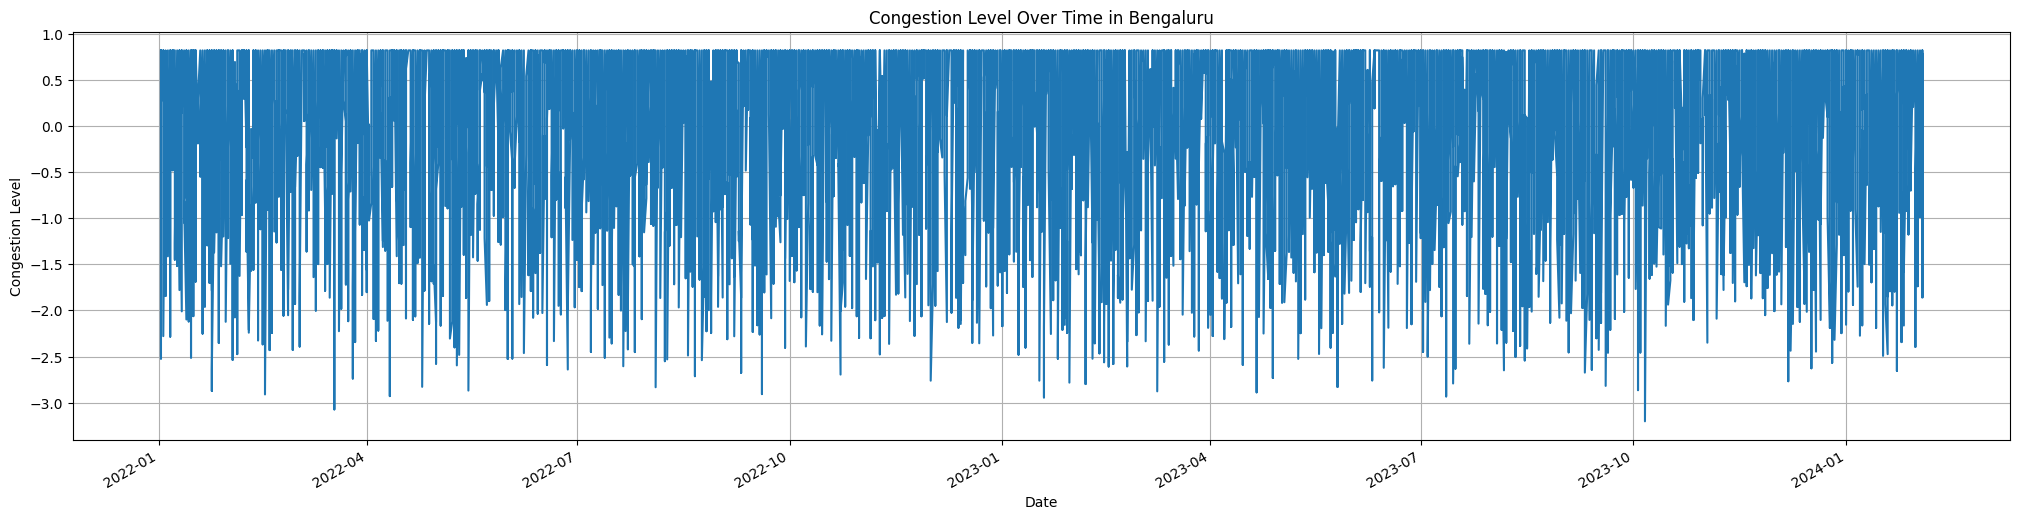

In [ ]:
plt.figure(figsize=(25, 6))
train_df['Congestion Level'].plot()
plt.title('Congestion Level Over Time in Bengaluru')
plt.ylabel('Congestion Level')
plt.xlabel('Date')
plt.grid(True)
plt.show()

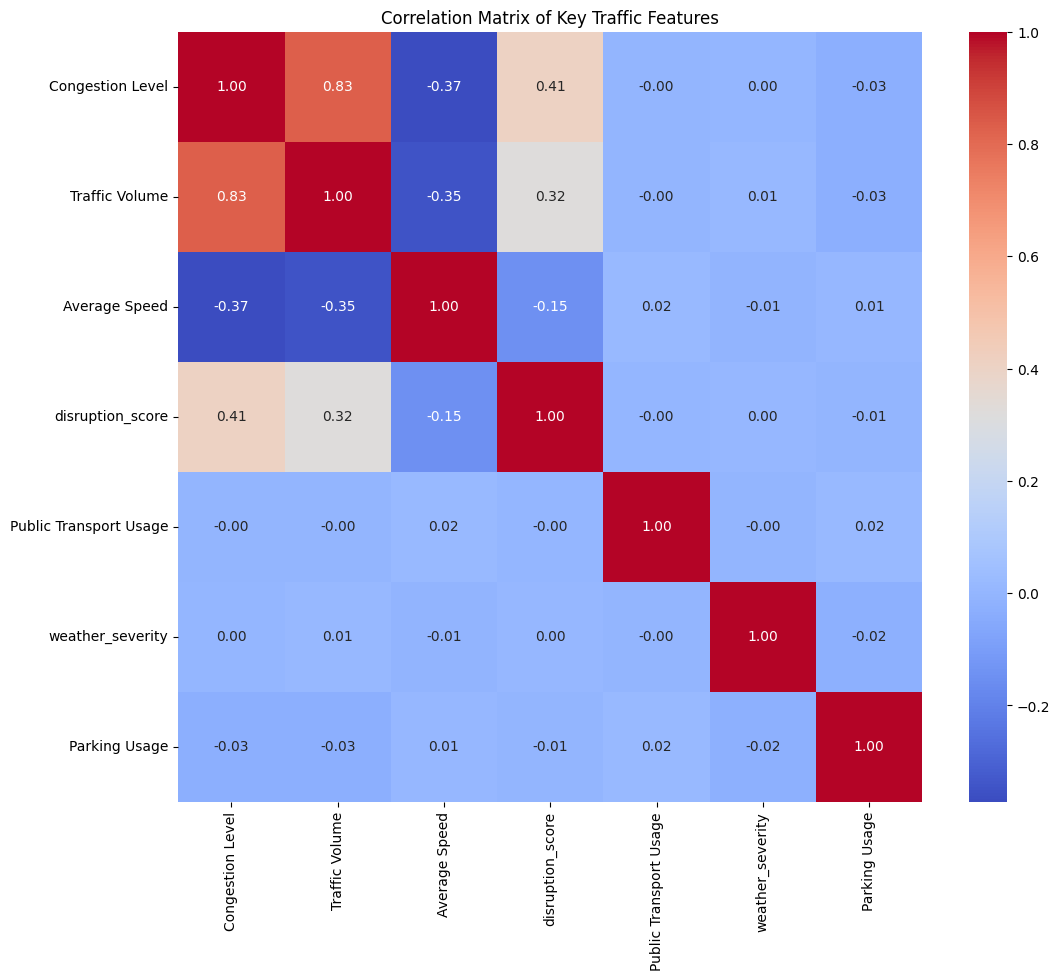

In [ ]:
plt.figure(figsize=(12, 10))
# Select a subset of columns for a cleaner heatmap
corr_cols = ['Congestion Level', 'Traffic Volume', 'Average Speed', 'disruption_score',
             'Public Transport Usage', 'weather_severity', 'Parking Usage']
correlation_matrix = train_df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Traffic Features')
plt.show()